In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
# checking and enabling gpu
#gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Import data and inspection

In [3]:
#transformation
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

#import the data and simulteniously apply transform
train_set = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_set.data.shape

(50000, 32, 32, 3)

In [5]:
test_set.data.shape

(10000, 32, 32, 3)

In [6]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_set.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
train_set.transforms

StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [14]:
# Creating dataloader object for the train and test sets
batch_sz = 32
train_loader = DataLoader(train_set,batch_size=batch_sz,drop_last=True,shuffle=True)
test_laoder = DataLoader(test_set, batch_size=256,drop_last=True,shuffle=True)

In [15]:
# cheking the shape of the datsets
print('Data shapes (train/dev/test) : ')
print(len(train_set))
print(len(test_set))

# and range of pixel intensity values
print('\nData value range:')
print( np.min(train_set.data), np.max(test_set.data) )

#printing the unique categories
print('\nData Categories: ')
print(train_set.classes)

Data shapes (train/dev/test) : 
50000
10000

Data value range:
0 255

Data Categories: 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [16]:
# Checking Transformation

X,y = next(iter(train_loader))
print(X.data.shape)

print('\nData value range: ')
print(  (torch.min(X.data),torch.max(X.data)))

torch.Size([32, 3, 32, 32])

Data value range: 
(tensor(-1.), tensor(1.))


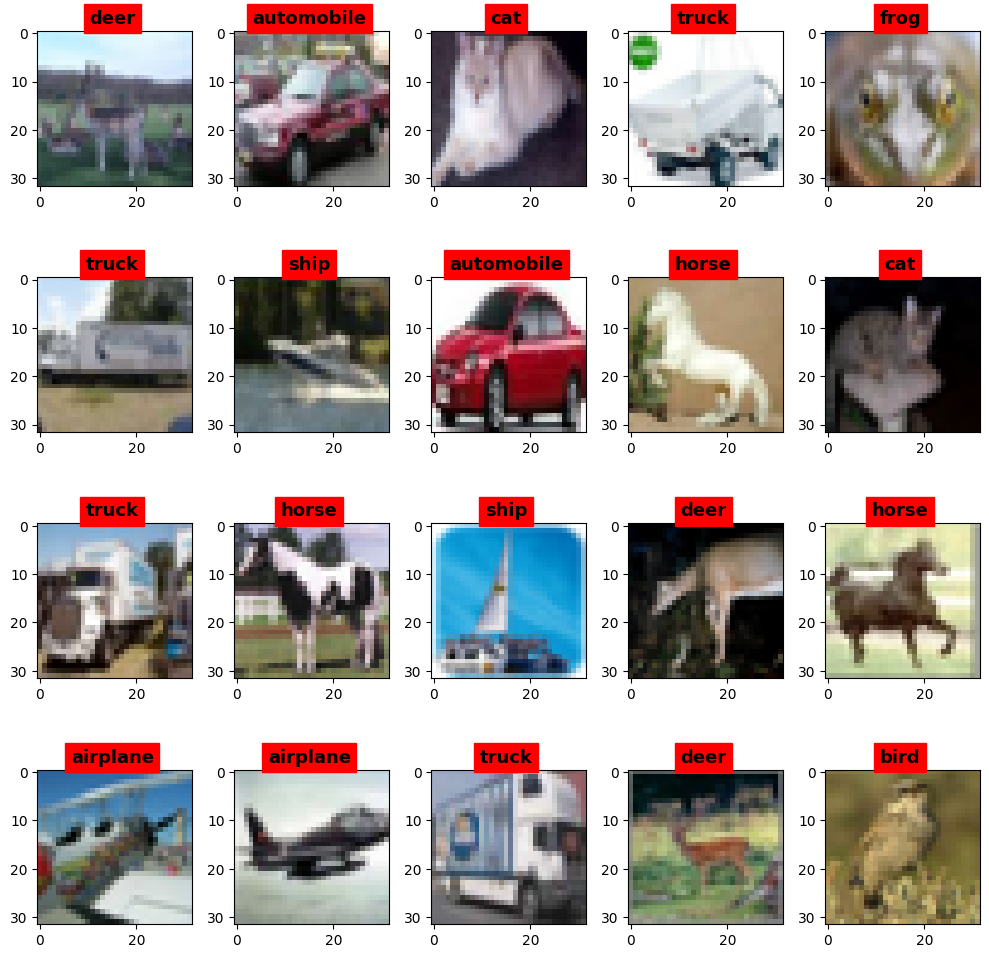

In [17]:
#some image inspections
fig,axs = plt.subplots(4,5,figsize = (10,10),dpi=100)

for (i,ax) in enumerate(axs.flatten()):
    #extractr imag (need to transpose is back to 32x32x3)
    pic = X.data[i].numpy().transpose((1,2,0))  # originally in torch it is --> [3,32,32] not it will be [32,32,3]
    pic = pic/2+.5 #undo normalization

    #label
    label = train_set.classes[y[i]]

    #and show
    ax.imshow(pic)
    ax.text(x=15,y=-2,s=label,fontweight='bold',fontsize=13,ha='center',backgroundcolor='r')
plt.tight_layout()
plt.show()

# Create the autoencoder

In [31]:
# create a class for the model
def make_cifar_ae(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-4)/2 + 1 = 16

      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8

      # third convolution layer (latent code layer)
      self.latent  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4


      ### -------------- decoding layers -------------- ###

      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)

      # second convolution layer
      self.decconv2  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # third convolution layer (output)
      self.output  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer
      x = F.leaky_relu( self.encconv1(x) )
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu( self.encconv2(x) )
      if self.print: print(f'Second encoder block: {list(x.shape)}')

      # latent layer
      x = F.leaky_relu( self.latent(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')




      # first decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')

      # second decoder block
      x = F.leaky_relu( self.decconv2(x) )
      if self.print: print(f'Second decoder block: {list(x.shape)}')

      # third decoder block (output)
      x = F.leaky_relu( self.output(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

# sanity test

In [32]:
# test the model with one batch
ae_net,lossfun,optimizer = make_cifar_ae()

X,y = iter(train_loader).next()
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(0.2940, grad_fn=<MseLossBackward0>)


# Function to train the model

In [45]:
# a function that trains the model

def function_to_train(net,lossfun,optimizer):

  # number of epochs
  numepochs = 20

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_laoder:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainLoss,testLoss,net

# Run the AE model and show the results

In [46]:
# create a new model (comment out to re-train)
netAE,lossfun,optimizer = make_cifar_ae()

trainLossAE,testLossAE,netAE = function_to_train(netAE,lossfun,optimizer)

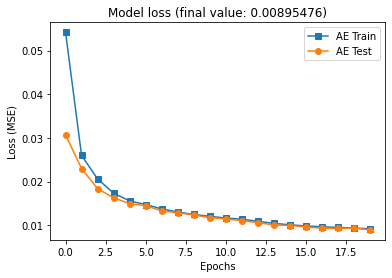

In [47]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final value: %g)'%testLossAE[-1])
plt.legend()

plt.show()

# show some random examples

In [48]:
# get some data
X,y = next(iter(test_laoder))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)
yHat.shape

torch.Size([256, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


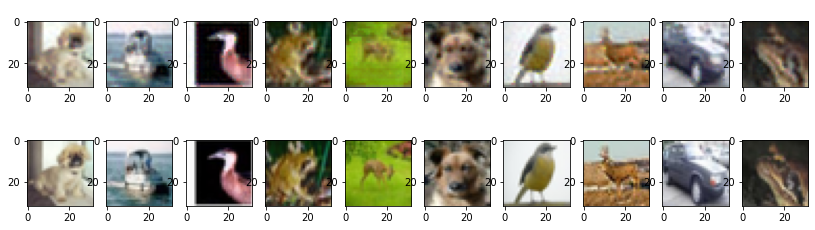

In [56]:
fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0)) # transposing into matplolibs acceptable size as torch's was (3,32,32) which is not sup[ported by matplotlib
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10,c='w')


  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10,c='w')



plt.show()

#data clipping as maplotlib doesn't support negative value
#supports [0, 1] and [0, 255]

# NICEEE Isn't it?